# LSTM Hyperparameter Optimized

In [1]:
!pip install -q optuna optuna-integration[tfkeras]


[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import optuna
import random
import os

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras import Sequential, Input, optimizers
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from optuna.integration import TFKerasPruningCallback

In [3]:
CSV_PATH   = "ALL_MERGED.csv"     # <--- set your CSV path
DATE_COL   = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True  # set False to exclude JKSE from X

# fixed split ratios (you can change)
TEST_SIZE  = 0.20
VAL_SIZE   = 0.10

# search budget
N_TRIALS   = 50                  # increase for better search
RANDOM_SEED = 31415

ALPHA = 0.05
Z_LEVEL = 1.96      # ~95% CI
ROLL_WIN = 30       # rolling window for PICP/MPIW
HEAT_WIN = 30       # window length for coverage heatmap
HEAT_STRIDE = 10    # stride between windows in coverage heatmap

print(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)

31415


In [4]:
df = pd.read_csv(CSV_PATH)

required = [
    "Date","Nickel_Fut","Coal_Fut_Newcastle","Palm_Oil_Fut",
    "USD_IDR","CNY_IDR","EUR_IDR","BTC_USD",
    "FTSE100","HANGSENG","NIKKEI225","SNP500","DOW30","SSE_Composite","JKSE"
]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df = df.sort_values(DATE_COL).set_index(DATE_COL)
df = df.ffill().bfill()
df

,Nickel_Fut,Coal_Fut_Newcastle,Palm_Oil_Fut,USD_IDR,CNY_IDR,EUR_IDR,BTC_USD,FTSE100,HANGSENG,NIKKEI225,SNP500,DOW30,SSE_Composite,JKSE
Date,,,,,,,,,,,,,,
2015-05-01,13750.00,62.20,2136,12962.5,2089.78,14519.9,232.078995,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-02,13750.00,62.20,2136,12962.5,2089.78,14519.9,234.929993,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-03,13750.00,62.20,2136,12962.5,2089.78,14519.9,240.358002,6986.000000,28123.82031,19531.63086,2108.290039,18024.06055,4480.463867,5140.937012
2015-05-04,13750.00,62.20,2136,12980.0,2090.51,14467.5,239.018005,6986.000000,28123.82031,19531.63086,2114.489990,18070.40039,4480.463867,5140.937012
2015-05-05,14245.00,62.50,2136,13047.5,2102.39,14594.9,236.121002,6927.600098,27755.53906,19531.63086,2089.459961,17928.19922,4298.706055,5160.107422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-27,15482.88,93.75,4057,16830.0,2309.37,19127.3,93754.843750,8415.299805,21980.74023,35705.73828,5525.209961,40113.50000,3295.060059,6678.915039
2025-04-28,15637.63,95.60,3943,16855.0,2310.59,19251.8,94978.750000,8417.299805,21971.96094,35839.98828,5528.750000,40227.58984,3288.415039,6722.965820
2025-04-29,15564.00,97.25,3911,16760.0,2305.52,19082.1,94284.789060,8463.500000,22008.10938,35839.98828,5560.830078,40527.62109,3286.655029,6749.075195


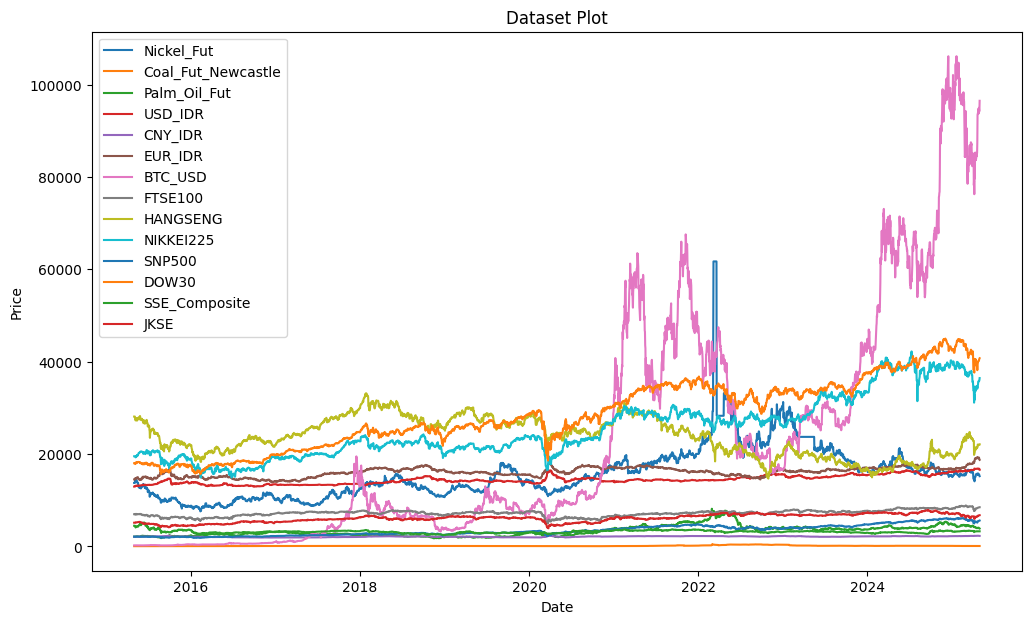

In [5]:
plt.figure(figsize=(12, 7))
plt.plot(df.index, df)
plt.title(f"Dataset Plot")
plt.xlabel("Date"); plt.ylabel("Price")
plt.legend(labels=df.columns)
plt.show()

In [6]:
n = len(df)
test_n = int(np.floor(TEST_SIZE * n))
trainval_n = n - test_n
val_n = int(np.floor(VAL_SIZE * trainval_n))
train_n = trainval_n - val_n

train_df = df.iloc[:train_n].copy()
val_df   = df.iloc[train_n:train_n + val_n].copy()
test_df  = df.iloc[train_n + val_n:].copy()

print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%) | "
      f"Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%) | "
      f"Test: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

Train: 2632 (72.0%) | Validation: 292 (8.0%) | Test: 730 (20.0%)


In [7]:
if INCLUDE_TARGET_AS_FEATURE:
    feature_cols = df.columns.tolist()          # includes TARGET_COL (JKSE)
else:
    feature_cols = [c for c in df.columns if c != TARGET_COL]

In [8]:
# feature_cols = [c for c in df.columns if c != TARGET_COL]
X_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaler.fit(train_df[feature_cols])
y_scaler.fit(train_df[[TARGET_COL]])

def scale_block(block):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return pd.DataFrame(X, index=block.index, columns=feature_cols), pd.DataFrame(y, index=block.index, columns=[TARGET_COL])

X_train_s, y_train_s = scale_block(train_df)
X_val_s,   y_val_s   = scale_block(val_df)
X_test_s,  y_test_s  = scale_block(test_df)

In [9]:
def make_windows(X_df, y_df, lookback):
    X_vals = X_df.values
    y_vals = y_df.values.squeeze()
    idx = X_df.index

    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i - lookback:i, :])
        y_list.append(y_vals[i])
        idx_list.append(idx[i])

    X_arr = np.array(X_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.float32)
    idx_arr = np.array(idx_list)
    return X_arr, y_arr, idx_arr

In [10]:
def compute_metrics(y_true, y_pred):
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return [mse, mae, rmse, mape, r2]

In [11]:
# Heteroscedastic Gaussian NLL Loss
def nll_gaussian_heteroscedastic(y_true, y_pred):
    """
    y_true: (batch,) or (batch,1)
    y_pred: (batch,2) = [mu_s, log_var_s]
    """
    y_true = tf.cast(tf.reshape(y_true, (-1,)), tf.float32)  # flatten
    mu      = y_pred[:, 0]
    log_var = tf.clip_by_value(y_pred[:, 1], -20.0, 5.0)     # stability
    inv_var = tf.exp(-log_var)
    nll = 0.5 * (log_var + (y_true - mu)**2 * inv_var)
    return tf.reduce_mean(nll)

In [12]:
def build_lstm(trial, lookback, n_features):
    # hyperparameters
    num_layers   = trial.suggest_int("num_layers", 1, 2)
    units1       = trial.suggest_int("units1", 32, 256, step=32)
    units2       = trial.suggest_int("units2", 32, 256, step=32) if num_layers == 2 else None
    dropout      = trial.suggest_float("dropout", 0.0, 0.5)
    lr           = trial.suggest_float("lr", 1e-4, 5e-3, log=True)

    model = Sequential()
    model.add(Input(shape=(lookback, n_features)))

    if num_layers == 2:
        model.add(LSTM(units1, return_sequences=True))
        model.add(Dropout(dropout))
        model.add(LSTM(units2))
    else:
        model.add(LSTM(units1))

    model.add(Dropout(dropout))
    model.add(Dense(2))  # (mu_s, log_var_s) in scaled space

    opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=nll_gaussian_heteroscedastic)
    return model


In [13]:
def objective(trial):
    # allow lookback to change per trial; rebuild windows
    lookback = trial.suggest_categorical("lookback", [30, 45, 60, 90])

    X_tr, y_tr, _ = make_windows(X_train_s, y_train_s, lookback)
    X_va, y_va, _ = make_windows(X_val_s,   y_val_s,   lookback)

    # reshape labels for safety (batch, 1)
    y_tr = y_tr.reshape(-1, 1)
    y_va = y_va.reshape(-1, 1)

    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    epochs     = trial.suggest_int("epochs", 30, 100, step=10)
    patience   = trial.suggest_int("patience", 5, 10)

    model = build_lstm(trial, lookback, n_features=len(feature_cols))

    callbacks = [
        EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True),
        TFKerasPruningCallback(trial, monitor="val_loss"),
    ]

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_va, y_va),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
        callbacks=callbacks,
    )

    # Return the best validation loss for this trial
    return min(history.history["val_loss"])


In [14]:
sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
pruner  = optuna.pruners.MedianPruner(n_warmup_steps=5)
study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)
print("\nStarting Optuna study...")

start_opt = time.time()
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)
end_opt = time.time()
print(f"Optuna finished in {end_opt - start_opt:.4f} seconds")
print("Best trial:", study.best_trial.number)
print("Best val_loss:", study.best_value)
print("Best params:", study.best_params)

best_params = study.best_params
BEST_LOOKBACK = best_params["lookback"]

[I 2025-11-30 03:26:31,244] A new study created in memory with name: no-name-a382ee63-d3a9-4fc3-a4ff-c05be56f5c82



Starting Optuna study...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-30 03:28:56,106] Trial 0 finished with value: -1.5190582275390625 and parameters: {'lookback': 60, 'batch_size': 32, 'epochs': 70, 'patience': 8, 'num_layers': 1, 'units1': 256, 'dropout': 0.3043032271576816, 'lr': 0.00015180290514006423}. Best is trial 0 with value: -1.5190582275390625.
[I 2025-11-30 03:32:25,151] Trial 1 finished with value: -2.010002851486206 and parameters: {'lookback': 90, 'batch_size': 64, 'epochs': 100, 'patience': 9, 'num_layers': 1, 'units1': 256, 'dropout': 0.0005295865660471799, 'lr': 0.003579811985336203}. Best is trial 1 with value: -2.010002851486206.
[I 2025-11-30 03:33:02,408] Trial 2 finished with value: -2.100562334060669 and parameters: {'lookback': 30, 'batch_size': 32, 'epochs': 30, 'patience': 5, 'num_layers': 1, 'units1': 128, 'dropout': 0.07231960839640239, 'lr': 0.004077570941232438}. Best is trial 2 with value: -2.100562334060669.
[I 2025-11-30 03:33:25,754] Trial 3 finished with value: -0.5136147737503052 and parameters: {'lookback

In [15]:
X_train_w, y_train_w, idx_train = make_windows(X_train_s, y_train_s, BEST_LOOKBACK)
X_val_w,   y_val_w,   idx_val   = make_windows(X_val_s,   y_val_s,   BEST_LOOKBACK)
X_test_w,  y_test_w,  idx_test  = make_windows(X_test_s,  y_test_s,  BEST_LOOKBACK)

In [16]:
final_model = Sequential()
final_model.add(Input(shape=(BEST_LOOKBACK, len(feature_cols))))

if best_params["num_layers"] == 2:
    final_model.add(LSTM(best_params["units1"], return_sequences=True))
    final_model.add(Dropout(best_params["dropout"]))
    final_model.add(LSTM(best_params["units2"]))
else:
    final_model.add(LSTM(best_params["units1"]))

final_model.add(Dropout(best_params["dropout"]))
final_model.add(Dense(2))  # heteroscedastic output (mu_s, log_var_s)

final_model.compile(
    optimizer=optimizers.Adam(learning_rate=best_params["lr"]),
    loss=nll_gaussian_heteroscedastic,
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=best_params["patience"], restore_best_weights=True),
    ModelCheckpoint("Model Checkpoints/lstm_optuna_best.keras", monitor="val_loss", save_best_only=True),
]

print("\nRetraining final LSTM on TRAIN (validate on VAL)...")
start_train = time.time()
history = final_model.fit(
    X_train_w, y_train_w,
    validation_data=(X_val_w, y_val_w),
    epochs=best_params["epochs"],
    batch_size=best_params["batch_size"],
    callbacks=callbacks,
    verbose=1,
)
end_train = time.time()
print(f"Final training time: {end_train - start_train:.4f} seconds")


Retraining final LSTM on TRAIN (validate on VAL)...
Epoch 1/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: -0.3945 - val_loss: -0.5499
Epoch 2/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: -1.3038 - val_loss: -0.1020
Epoch 3/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: -1.5736 - val_loss: -1.2015
Epoch 4/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: -1.6406 - val_loss: -0.2372
Epoch 5/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: -1.7548 - val_loss: -1.8970
Epoch 6/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: -1.7586 - val_loss: -1.5211
Epoch 7/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: -1.7973 - val_loss: -1.8687
Epoch 8/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: -1.9145 - val_loss: -1.6764
Epoch 9/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: -1.9403 - val_loss: -1.9083
Epoch 10/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: -1.9340 - val_loss: -1.9242
Epoch 11/30
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: -2.0157 - val_lo

In [17]:
# Last-Layer Laplace Approximation (LLLA)
# last layer is Dense(2), so penultimate layer is layers[-2]
penultimate_layer = final_model.layers[-2]

phi_model = tf.keras.Model(
    inputs=final_model.layers[0].input,  # robust way for Sequential models
    outputs=penultimate_layer.output     # φ(x)
)

# Get features for each split
phi_train = phi_model.predict(X_train_w, verbose=0)  # (N_train, H)
phi_val   = phi_model.predict(X_val_w,   verbose=0)  # (N_val,   H)
phi_test  = phi_model.predict(X_test_w,  verbose=0)  # (N_test,  H)

print("phi_train shape:", phi_train.shape)
print("phi_val shape:",   phi_val.shape)
print("phi_test shape:",  phi_test.shape)

phi_train shape: (2602, 160)
phi_val shape: (262, 160)
phi_test shape: (700, 160)


In [18]:
# Get MAP predictions in scaled space for training data
yhat_train_s = final_model.predict(X_train_w, verbose=0)  # (N_train, 2)
mu_train_s   = yhat_train_s[:, 0]                         # only mean head

# y_train_w is already scaled (comes from y_train_s via make_windows)
y_true_train_s = y_train_w  # (N_train,)

# Estimate noise variance σ_n^2 in scaled space
residuals_train_s = y_true_train_s - mu_train_s
sigma_n2 = np.mean(residuals_train_s**2)
print("Estimated noise variance (scaled):", sigma_n2)

Estimated noise variance (scaled): 0.0045525515


In [19]:
# Build extended features Φ = [φ, 1] for bias
N_train, H = phi_train.shape

Phi_train = np.concatenate(
    [phi_train, np.ones((N_train, 1), dtype=phi_train.dtype)],
    axis=1
)  # shape (N_train, H+1)

# Prior precision (ridge term)
lambda_prior = 1.0  # you can tune this (e.g., 0.1, 1.0, 10.0)

# Diagonal Hessian approximation: H_diag = (1/σ_n^2) * sum_i φ_i^2 + λ
H_diag = (1.0 / sigma_n2) * np.sum(Phi_train**2, axis=0) + lambda_prior  # (H+1,)

# Posterior variance of weights: diag(Σ) = 1 / H_diag
var_w_diag = 1.0 / H_diag  # (H+1,)

print("var_w_diag shape:", var_w_diag.shape)

var_w_diag shape: (161,)


In [20]:
# Helper to compute epistemic std for any split
y_std = y_scaler.scale_[0]

def compute_sigma_epi(phi_block, idx_block):
    N, H = phi_block.shape
    Phi_block = np.concatenate(
        [phi_block, np.ones((N, 1), dtype=phi_block.dtype)],
        axis=1
    )  # (N, H+1)

    # Var_epi in scaled space: Φ Σ Φ^T (diagonal only with diag Σ)
    var_epi_scaled = np.sum((Phi_block**2) * var_w_diag.reshape(1, -1), axis=1)  # (N,)
    var_epi_orig   = var_epi_scaled * (y_std**2)
    sigma_epi_orig = np.sqrt(np.maximum(var_epi_orig, 1e-12))  # avoid negatives

    return pd.Series(sigma_epi_orig, index=idx_block, name="sigma_epi")

# Compute epistemic std for each split
sigma_epi_train = compute_sigma_epi(phi_train, idx_train)
sigma_epi_val   = compute_sigma_epi(phi_val,   idx_val)
sigma_epi_test  = compute_sigma_epi(phi_test,  idx_test)

print(sigma_epi_train.head())
print(sigma_epi_val.head())
print(sigma_epi_test.head())

2015-05-31    11.311154
2015-06-01    11.301960
2015-06-02    11.584336
2015-06-03    11.792842
2015-06-04    12.178936
Name: sigma_epi, dtype: float32
2022-08-14    19.751451
2022-08-15    19.668957
2022-08-16    19.403273
2022-08-17    19.875565
2022-08-18    19.661322
Name: sigma_epi, dtype: float32
2023-06-02    13.653412
2023-06-03    13.615083
2023-06-04    13.527663
2023-06-05    13.550826
2023-06-06    13.418671
Name: sigma_epi, dtype: float32


In [21]:
def predict_series_hetero(model, X_block, idx_block):
    yhat_s = model.predict(X_block, verbose=0)   # (N,2)
    mu_s      = yhat_s[:, 0]
    log_var_s = yhat_s[:, 1]

    # scale back
    mu_orig = mu_s * y_scaler.scale_[0] + y_scaler.mean_[0]
    var_orig = np.exp(log_var_s) * (y_scaler.scale_[0] ** 2)
    sigma_ale = np.sqrt(var_orig)

    df_out = pd.DataFrame({
        "mu": mu_orig,
        "sigma_ale": sigma_ale
    }, index=idx_block)

    return df_out

pred_train = predict_series_hetero(final_model, X_train_w, idx_train)
pred_val   = predict_series_hetero(final_model, X_val_w,   idx_val)

start_test = time.time()
pred_test  = predict_series_hetero(final_model, X_test_w,  idx_test)
end_test = time.time()
print(f"Testing (inference) time: {end_test - start_test:.4f} seconds")

Testing (inference) time: 0.2751 seconds


In [22]:
# === Combine aleatoric + epistemic ===
sigma_ale_train = pred_train["sigma_ale"]
sigma_ale_val   = pred_val["sigma_ale"]
sigma_ale_test  = pred_test["sigma_ale"]

sigma_total_train = np.sqrt(sigma_ale_train**2 + sigma_epi_train**2)
sigma_total_val   = np.sqrt(sigma_ale_val**2   + sigma_epi_val**2)
sigma_total_test  = np.sqrt(sigma_ale_test**2  + sigma_epi_test**2)

# Attach back to prediction DataFrames for convenience
pred_train["sigma_epi"]   = sigma_epi_train
pred_val["sigma_epi"]     = sigma_epi_val
pred_test["sigma_epi"]    = sigma_epi_test

pred_train["sigma_total"] = sigma_total_train
pred_val["sigma_total"]   = sigma_total_val
pred_test["sigma_total"]  = sigma_total_test

pred_train.head(), pred_val.head(), pred_test.head()

(                     mu  sigma_ale  sigma_epi  sigma_total
 2015-05-31  5244.718262  54.813107  11.311154    55.968014
 2015-06-01  5244.159180  54.765026  11.301960    55.919071
 2015-06-02  5241.138184  54.924526  11.584336    56.132881
 2015-06-03  5237.320801  55.313534  11.792842    56.556679
 2015-06-04  5179.310547  55.652969  12.178936    56.969986,
                      mu  sigma_ale  sigma_epi  sigma_total
 2022-08-14  7129.897461  58.750122  19.751451    61.981422
 2022-08-15  7121.771484  59.309464  19.668957    62.485844
 2022-08-16  7086.983887  60.390785  19.403273    63.431332
 2022-08-17  7123.612305  57.089504  19.875565    60.450390
 2022-08-18  7103.609863  58.924908  19.661322    62.118534,
                      mu  sigma_ale  sigma_epi  sigma_total
 2023-06-02  6578.878418  45.864010  13.653412    47.853138
 2023-06-03  6587.418457  45.480675  13.615083    47.474861
 2023-06-04  6581.793945  46.051353  13.527663    47.997131
 2023-06-05  6584.163086  45.828922  1

In [23]:
actual       = df[TARGET_COL]
actual_train = actual.loc[idx_train]
actual_val   = actual.loc[idx_val]
actual_test  = actual.loc[idx_test]

metrics_train = compute_metrics(actual_train.values, pred_train["mu"].values)
metrics_val   = compute_metrics(actual_val.values,   pred_val["mu"].values)
metrics_test  = compute_metrics(actual_test.values,  pred_test["mu"].values)

metrics_df = pd.DataFrame(
    [metrics_train, metrics_val, metrics_test],
    columns=["MSE", "MAE", "RMSE", "MAPE", "R²"],
    index=["Train", "Validation", "Test"]
)

pd.set_option("display.float_format", "{:.4f}".format)
print("\n=== Metrics Summary (LSTM — Hetero + LLLA) ===")
print(metrics_df.round(4))



=== Metrics Summary (LSTM — Hetero + LLLA) ===
                  MSE      MAE     RMSE   MAPE     R²
Train       2275.0108  33.3528  47.6971 0.0059 0.9955
Validation  2154.5544  35.9423  46.4172 0.0052 0.9205
Test       35491.2386 166.5037 188.3912 0.0231 0.6851


In [24]:
def compute_pi_metrics_from_sigma(y_true, mu, sigma, z_level=1.96, alpha=0.05):
    """
    Compute PICP, MPIW, Winkler Score for prediction intervals.
    """
    y_true = np.asarray(y_true, dtype=float)
    mu     = np.asarray(mu, dtype=float)
    sigma  = np.asarray(sigma, dtype=float)

    # Prediction intervals
    L = mu - z_level * sigma
    U = mu + z_level * sigma

    # PICP (coverage)
    inside = (y_true >= L) & (y_true <= U)
    picp = inside.mean()

    # MPIW (mean interval width)
    width = U - L
    mpiw = width.mean()

    # Winkler score
    penalties = np.zeros_like(y_true)
    
    below = y_true < L
    above = y_true > U
    
    penalties[below] = (L[below] - y_true[below])
    penalties[above] = (y_true[above] - U[above])
    
    winkler = np.mean(width + (2.0 / alpha) * penalties)

    return picp, mpiw, winkler

lstm_picp_train, lstm_mpiw_train, lstm_wink_train = compute_pi_metrics_from_sigma(
    actual_train.values,
    pred_train["mu"].values,
    pred_train["sigma_total"].values,
    z_level=Z_LEVEL,
    alpha=ALPHA
)

lstm_picp_val, lstm_mpiw_val, lstm_wink_val = compute_pi_metrics_from_sigma(
    actual_val.values,
    pred_val["mu"].values,
    pred_val["sigma_total"].values,
    z_level=Z_LEVEL,
    alpha=ALPHA
)

lstm_picp_test, lstm_mpiw_test, lstm_wink_test = compute_pi_metrics_from_sigma(
    actual_test.values,
    pred_test["mu"].values,
    pred_test["sigma_total"].values,
    z_level=Z_LEVEL,
    alpha=ALPHA
)

print("\n=== UQ Interval Metrics (LSTM — Heteroscedastic + LLLA) ===")
print(f"TRAIN — PICP: {lstm_picp_train:.4f} | MPIW: {lstm_mpiw_train:.4f} | Winkler: {lstm_wink_train:.4f}")
print(f"VAL   — PICP: {lstm_picp_val:.4f} | MPIW: {lstm_mpiw_val:.4f} | Winkler: {lstm_wink_val:.4f}")
print(f"TEST  — PICP: {lstm_picp_test:.4f} | MPIW: {lstm_mpiw_test:.4f} | Winkler: {lstm_wink_test:.4f}")



=== UQ Interval Metrics (LSTM — Heteroscedastic + LLLA) ===
TRAIN — PICP: 0.9685 | MPIW: 214.7664 | Winkler: 248.4598
VAL   — PICP: 0.9885 | MPIW: 256.3939 | Winkler: 263.0664
TEST  — PICP: 0.1886 | MPIW: 164.7465 | Winkler: 3746.7822


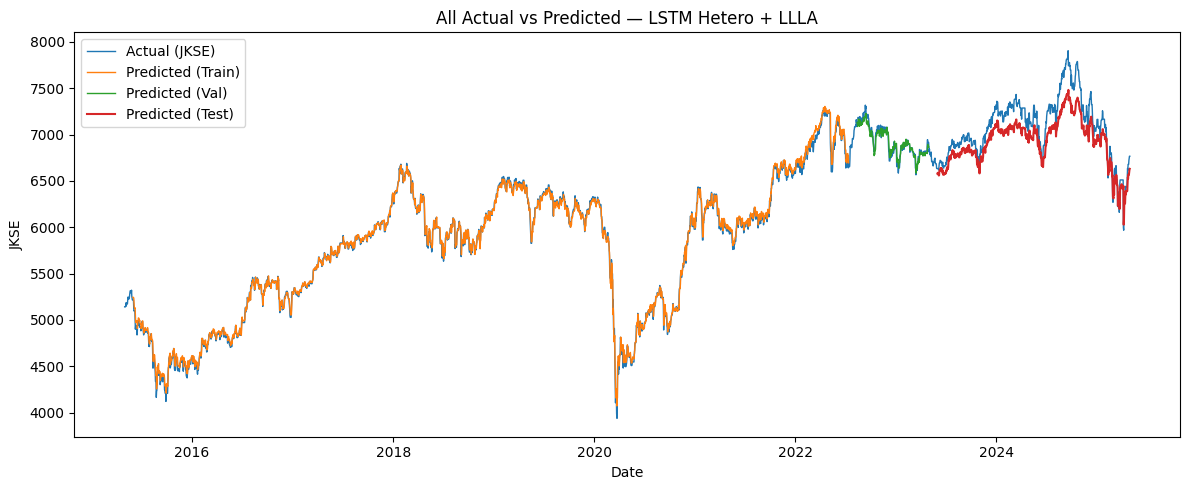

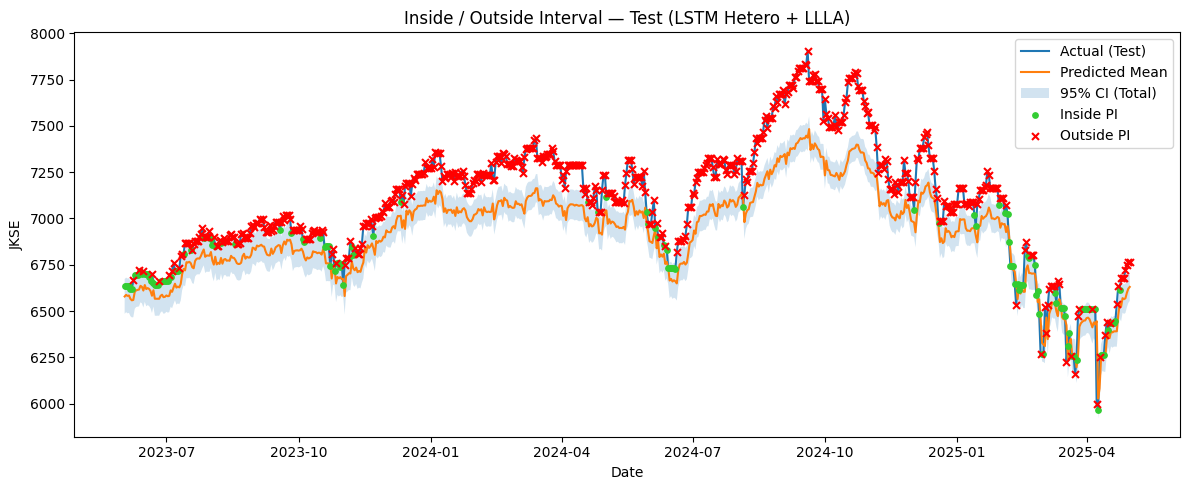

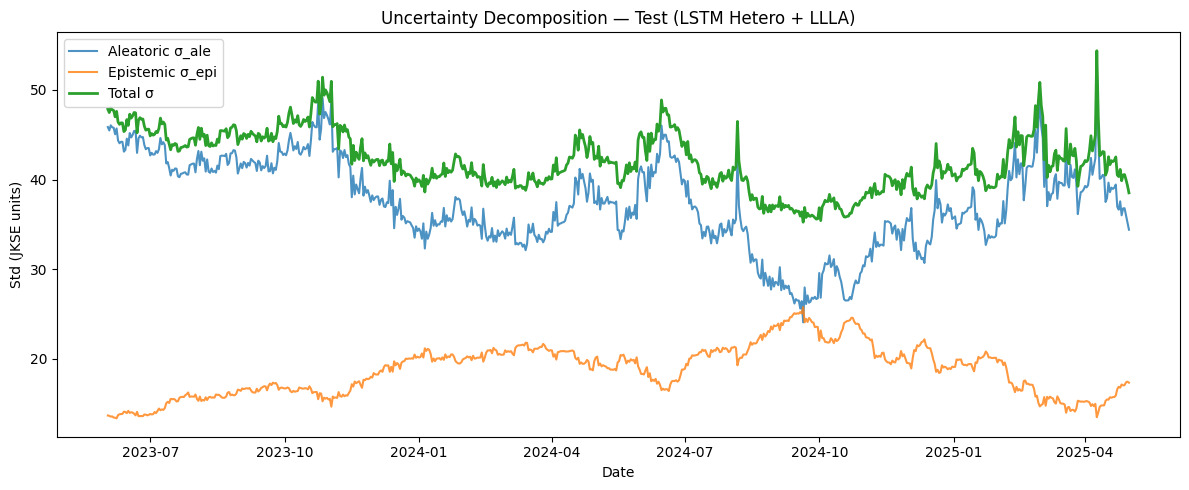

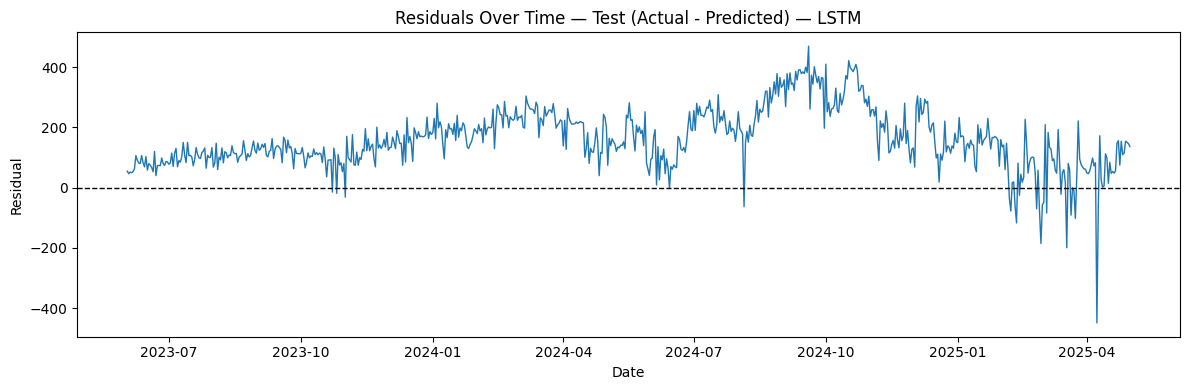

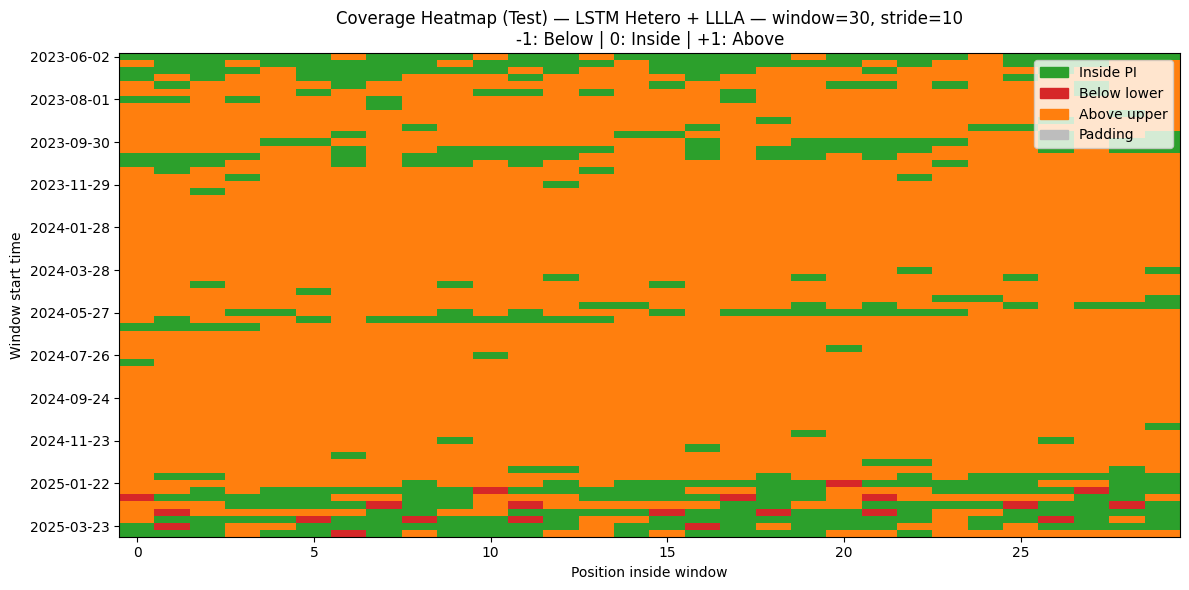

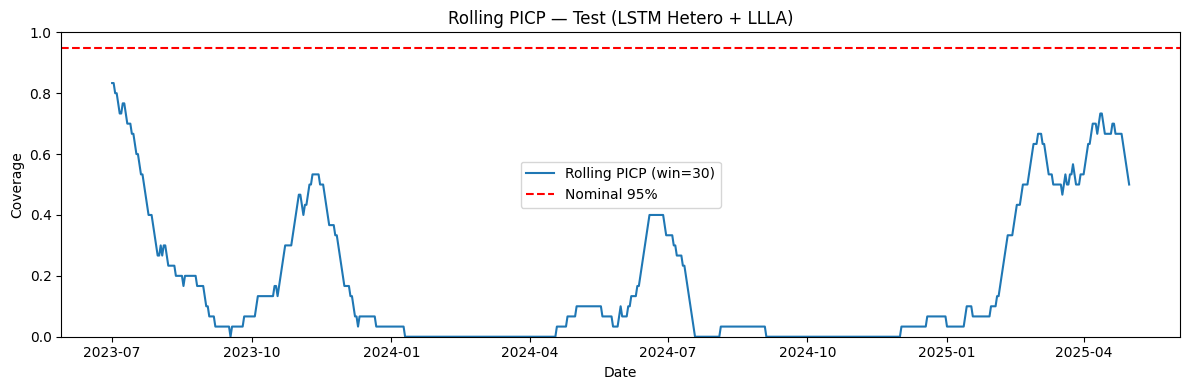

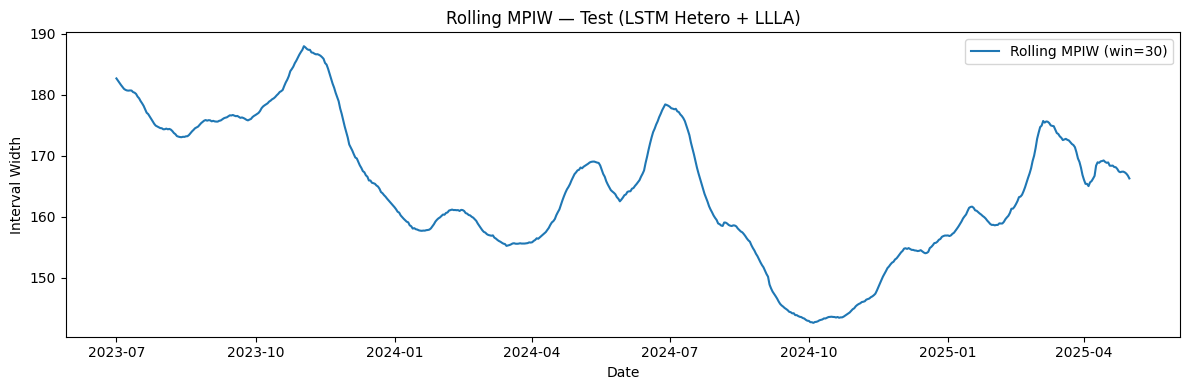

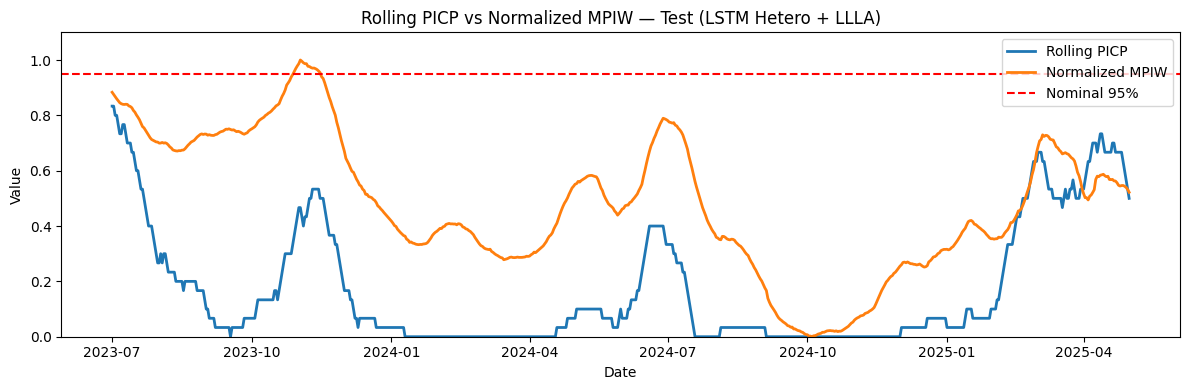

In [25]:
# Convenience aliases
mu_train = pred_train["mu"]
mu_val   = pred_val["mu"]
mu_test  = pred_test["mu"]

sigma_ale_train = pred_train["sigma_ale"]
sigma_ale_val   = pred_val["sigma_ale"]
sigma_ale_test  = pred_test["sigma_ale"]

sigma_epi_train  = pred_train["sigma_epi"]
sigma_epi_val    = pred_val["sigma_epi"]
sigma_epi_test   = pred_test["sigma_epi"]

sigma_total_train = pred_train["sigma_total"]
sigma_total_val   = pred_val["sigma_total"]
sigma_total_test  = pred_test["sigma_total"]

# Build total intervals for test set
L_test = mu_test - Z_LEVEL * sigma_total_test
U_test = mu_test + Z_LEVEL * sigma_total_test

# (1) ALL ACTUAL vs PREDICTED (Train / Val / Test)
plt.figure(figsize=(12, 5))
plt.plot(actual.index, actual.values, label="Actual (JKSE)", linewidth=1)
plt.plot(mu_train.index, mu_train.values, label="Predicted (Train)", linewidth=1)
plt.plot(mu_val.index,   mu_val.values,   label="Predicted (Val)", linewidth=1)
plt.plot(mu_test.index,  mu_test.values,  label="Predicted (Test)", linewidth=1.5)
plt.title("All Actual vs Predicted — LSTM Hetero + LLLA")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend(); plt.tight_layout(); plt.show()

# (2) INSIDE (GREEN) / OUTSIDE (RED) — TEST ONLY
y_true_test = actual_test

inside_mask = (y_true_test >= L_test) & (y_true_test <= U_test)
outside_mask = ~inside_mask

plt.figure(figsize=(12, 5))
plt.plot(y_true_test.index, y_true_test.values, label="Actual (Test)", linewidth=1.5)
plt.plot(mu_test.index, mu_test.values, label="Predicted Mean", linewidth=1.5)
plt.fill_between(mu_test.index, L_test.values, U_test.values, alpha=0.2, label="95% CI (Total)")
plt.scatter(y_true_test.index[inside_mask], y_true_test.values[inside_mask], s=15, label="Inside PI", zorder=3, color="limegreen")
plt.scatter(y_true_test.index[outside_mask], y_true_test.values[outside_mask], s=25, marker="x", label="Outside PI", zorder=3, color="red")
plt.title("Inside / Outside Interval — Test (LSTM Hetero + LLLA)")
plt.xlabel("Date"); plt.ylabel("JKSE")
plt.legend(); plt.tight_layout(); plt.show()

# (3) UNCERTAINTY DECOMPOSITION — TEST
plt.figure(figsize=(12, 5))
plt.plot(sigma_ale_test.index,   sigma_ale_test.values,   label="Aleatoric σ_ale", alpha=0.8)
plt.plot(sigma_epi_test.index,   sigma_epi_test.values,   label="Epistemic σ_epi", alpha=0.8)
plt.plot(sigma_total_test.index, sigma_total_test.values, label="Total σ", linewidth=2)
plt.title("Uncertainty Decomposition — Test (LSTM Hetero + LLLA)")
plt.xlabel("Date"); plt.ylabel("Std (JKSE units)")
plt.legend(); plt.tight_layout(); plt.show()

# (4) RESIDUALS OVER TIME — TEST
residuals_test = y_true_test.values - mu_test.values

plt.figure(figsize=(12, 4))
plt.plot(y_true_test.index, residuals_test, linewidth=1)
plt.axhline(0, linestyle="--", linewidth=1, color="black")
plt.title("Residuals Over Time — Test (Actual - Predicted) — LSTM")
plt.xlabel("Date"); plt.ylabel("Residual")
plt.tight_layout(); plt.show()

# (5) COVERAGE HEATMAP (PER-WINDOW) — TEST
y_true = y_true_test.values
L_arr  = L_test.values
U_arr  = U_test.values

below_mask  = (y_true < L_arr)
above_mask  = (y_true > U_arr)
inside_mask = (y_true >= L_arr) & (y_true <= U_arr)

status = np.zeros_like(y_true, dtype=float)
status[below_mask] = -1
status[above_mask] = 1

starts = np.arange(0, len(status) - HEAT_WIN + 1, HEAT_STRIDE)
if len(starts) == 0:
    starts = np.array([0])
    HEAT_WIN = len(status)

mat = []
x_tick_labels = []

for s in starts:
    e = min(s + HEAT_WIN, len(status))
    row = status[s:e]
    if e - s < HEAT_WIN:
        row = np.pad(row, (0, HEAT_WIN - (e - s)), constant_values=np.nan)
    mat.append(row)
    x_tick_labels.append(y_true_test.index[s].strftime("%Y-%m-%d"))

mat = np.vstack(mat)

cmap = ListedColormap(["#d62728", "#2ca02c", "#ff7f0e", "#bdbdbd"])
bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(12, 6))
plt.imshow(mat, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm)
plt.title(f"Coverage Heatmap (Test) — LSTM Hetero + LLLA — window={HEAT_WIN}, stride={HEAT_STRIDE}\n-1: Below | 0: Inside | +1: Above")
plt.xlabel("Position inside window")
plt.ylabel("Window start time")

yticks = np.arange(0, len(starts), max(1, len(starts) // 10))
plt.yticks(yticks, [x_tick_labels[i] for i in yticks])

legend_patches = [
    mpatches.Patch(color="#2ca02c", label="Inside PI"),
    mpatches.Patch(color="#d62728", label="Below lower"),
    mpatches.Patch(color="#ff7f0e", label="Above upper"),
    mpatches.Patch(color="#bdbdbd", label="Padding"),
]
plt.legend(handles=legend_patches, loc="upper right", frameon=True)
plt.tight_layout(); plt.show()

# (6) ROLLING PICP — TEST (Total intervals)
covered = ((y_true_test >= L_test) & (y_true_test <= U_test)).astype(int)
rolling_picp = covered.rolling(ROLL_WIN).mean()

plt.figure(figsize=(12, 4))
plt.plot(rolling_picp.index, rolling_picp.values, label=f"Rolling PICP (win={ROLL_WIN})")
plt.axhline(0.95, color="red", linestyle="--", label="Nominal 95%")
plt.title("Rolling PICP — Test (LSTM Hetero + LLLA)")
plt.xlabel("Date"); plt.ylabel("Coverage")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout(); plt.show()

# (7) ROLLING MPIW — TEST (Total intervals)
width = (U_test - L_test)
rolling_mpiw = width.rolling(ROLL_WIN).mean()

plt.figure(figsize=(12, 4))
plt.plot(rolling_mpiw.index, rolling_mpiw.values, label=f"Rolling MPIW (win={ROLL_WIN})")
plt.title("Rolling MPIW — Test (LSTM Hetero + LLLA)")
plt.xlabel("Date"); plt.ylabel("Interval Width")
plt.legend()
plt.tight_layout(); plt.show()

# (8) ROLLING PICP + NORMALIZED MPIW — TEST
mpiwn = (rolling_mpiw - rolling_mpiw.min()) / (rolling_mpiw.max() - rolling_mpiw.min() + 1e-12)

plt.figure(figsize=(12, 4))
plt.plot(rolling_picp.index, rolling_picp.values, label="Rolling PICP", linewidth=2)
plt.plot(mpiwn.index, mpiwn.values, label="Normalized MPIW", linewidth=2)
plt.axhline(0.95, color="red", linestyle="--", label="Nominal 95%")
plt.title("Rolling PICP vs Normalized MPIW — Test (LSTM Hetero + LLLA)")
plt.xlabel("Date"); plt.ylabel("Value")
plt.ylim(0, 1.1)
plt.legend()
plt.tight_layout(); plt.show()

In [26]:
# === CONFIGURATION ===
results_dir = os.path.join("..", "Results")
predicted_path = os.path.join(results_dir, "ALL_UQ_PREDICTED.csv")
metrics_path = os.path.join(results_dir, "ALL_UQ_METRICS.csv")

# Manual model name (since __file__ isn't available in notebooks)
model = "lstm_hllla"
model_name = f"{model}_{RANDOM_SEED}"   # change this for each notebook (e.g., GRU_Baseline)
print("Model Name for Documentation:", model_name)

# Create Results directory if not exists
os.makedirs(results_dir, exist_ok=True)

# ==========================================
# 1️⃣ PREPARE AND ALIGN TESTING DATAFRAME
# ==========================================

# Convert dates
test_dates = test_df.index.to_series().reset_index(drop=True)
actual_values = test_df[TARGET_COL].values

# If ALL_PREDICTED doesn't exist, create the base file
if not os.path.exists(predicted_path):
    print("Creating ALL_PREDICTED.csv ...")
    base_df = pd.DataFrame({
        "date": test_dates,
        "actual": actual_values
    })
    base_df.to_csv(predicted_path, index=False)

# Load and ensure datetime consistency
all_pred_df = pd.read_csv(predicted_path)
all_pred_df["date"] = pd.to_datetime(all_pred_df["date"])

# Ensure the file covers full test range (in case it was made from smaller data)
base_df = pd.DataFrame({
    "date": test_dates,
    "actual": actual_values
})
# Outer merge to make sure we have the full timeline
all_pred_df = pd.merge(base_df, all_pred_df, on=["date", "actual"], how="outer")

# Create new prediction column (aligned to date)
pred_series = pd.Series(mu_test.values, index=pd.to_datetime(idx_test), name=model_name)
pred_series = pred_series.reindex(all_pred_df["date"])  # align by date

# Create lower and upper bound series (aligned to date)
L_series = pd.Series(L_test.values, index=pd.to_datetime(idx_test), name=f"{model_name}_L")
U_series = pd.Series(U_test.values, index=pd.to_datetime(idx_test), name=f"{model_name}_U")
L_series = L_series.reindex(all_pred_df["date"])  # align by date
U_series = U_series.reindex(all_pred_df["date"])  # align by date

# Add or update the model column
all_pred_df[model_name] = pred_series.values
all_pred_df[f"{model_name}_L"] = L_series.values  # Add lower bound
all_pred_df[f"{model_name}_U"] = U_series.values  # Add upper bound

# Sort and save
all_pred_df = all_pred_df.sort_values("date").reset_index(drop=True)
all_pred_df.to_csv(predicted_path, index=False)
print(f"✅ Predictions saved to {predicted_path}")

# ==========================================
# 2️⃣ RECORD METRICS SUMMARY
# ==========================================
metrics_columns = [
    "timestamp",
    "model_name", 
    "seed",
    "mse",
    "mae",
    "rmse", 
    "mape",
    "r2_score",
    "picp",
    "mpiw",
    "winkler_score",
    "training_time_s",
    "testing_time_s", 
    "hpo_trial_s",
    "hpo_time_s"
]

# Create ALL_METRICS if missing
if not os.path.exists(metrics_path):
    print("Creating ALL_METRICS.csv ...")
    pd.DataFrame(columns=metrics_columns).to_csv(metrics_path, index=False)

# Current timestamp
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Extract metrics
mse, mae, rmse, mape, r2 = compute_metrics(actual_test.values, mu_test.values)
picp, mpiw, winkler = compute_pi_metrics_from_sigma(actual_test.values, L_test.values, U_test.values, ALPHA)

# Build metrics row
metrics_row = {
    "timestamp": timestamp,
    "model_name": model_name,
    "seed": RANDOM_SEED,
    "mse": mse,
    "mae": mae,
    "rmse": rmse,
    "mape": mape,
    "r2_score": r2,
    "picp": picp,
    "mpiw": mpiw,
    "winkler_score": winkler,
    "training_time_s": round(end_train - start_train, 4),
    "testing_time_s": round(end_test - start_test, 4),
    "hpo_trial_s": N_TRIALS,
    "hpo_time_s": round(end_opt - start_opt, 4),
}

# Append metrics
all_metrics_df = pd.read_csv(metrics_path)
all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics_row])], ignore_index=True)
all_metrics_df.to_csv(metrics_path, index=False)
print(f"✅ Metrics appended to {metrics_path}")

print("\n📄 Documentation of predictions and metrics completed successfully.")


Model Name for Documentation: lstm_hllla_31415
✅ Predictions saved to ..\Results\ALL_UQ_PREDICTED.csv
✅ Metrics appended to ..\Results\ALL_UQ_METRICS.csv

📄 Documentation of predictions and metrics completed successfully.
